# Machine Learning
We apply a Random Forest classifier to our timelag and correlation calculations over the whole AR.

In [1]:
import os
import sys

import numpy as np
from scipy.interpolate import splev
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.map import Map,GenericMap
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import dask
import distributed
#from dask_ml.model_selection import RandomizedSearchCV
#from dask_ml.model_selection import train_test_split as dask_train_test_split

from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import bgry_004_idl_cmap

sys.path.append('../paper/python/')
from formatting import get_figsize,heating_palette,qualitative_palette,heating_cmap
from classify import prep_data, classify_ar

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

## Data Prep and Import
First, we need to import all of our timelag and correlation data, both modeled and observed, into data matrices, $X$, $Y$, and $X_{obs}$

In [2]:
heating = ['high_frequency', 'intermediate_frequency', 'low_frequency',]
channels = [94,131,171,193,211,335]
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]
correlation_threshold = 0.1
rsquared_threshold = 0.75

In [3]:
file_format = '../paper/data/{}/{}_{}_{}.fits'

We want to exclude correlations $<0.1$ and NaN EM slopes from our training data set. We'll create a composite mask over the whole AR for these criteria.

In [4]:
X, Y, X_observation, bad_pixels = prep_data(
    '../paper/data/',
    channel_pairs,
    heating,
    correlation_threshold=correlation_threshold,
    rsquared_threshold=rsquared_threshold,
    scale_slope=False,
    scale_timelag=False,
    scale_correlation=False,
)

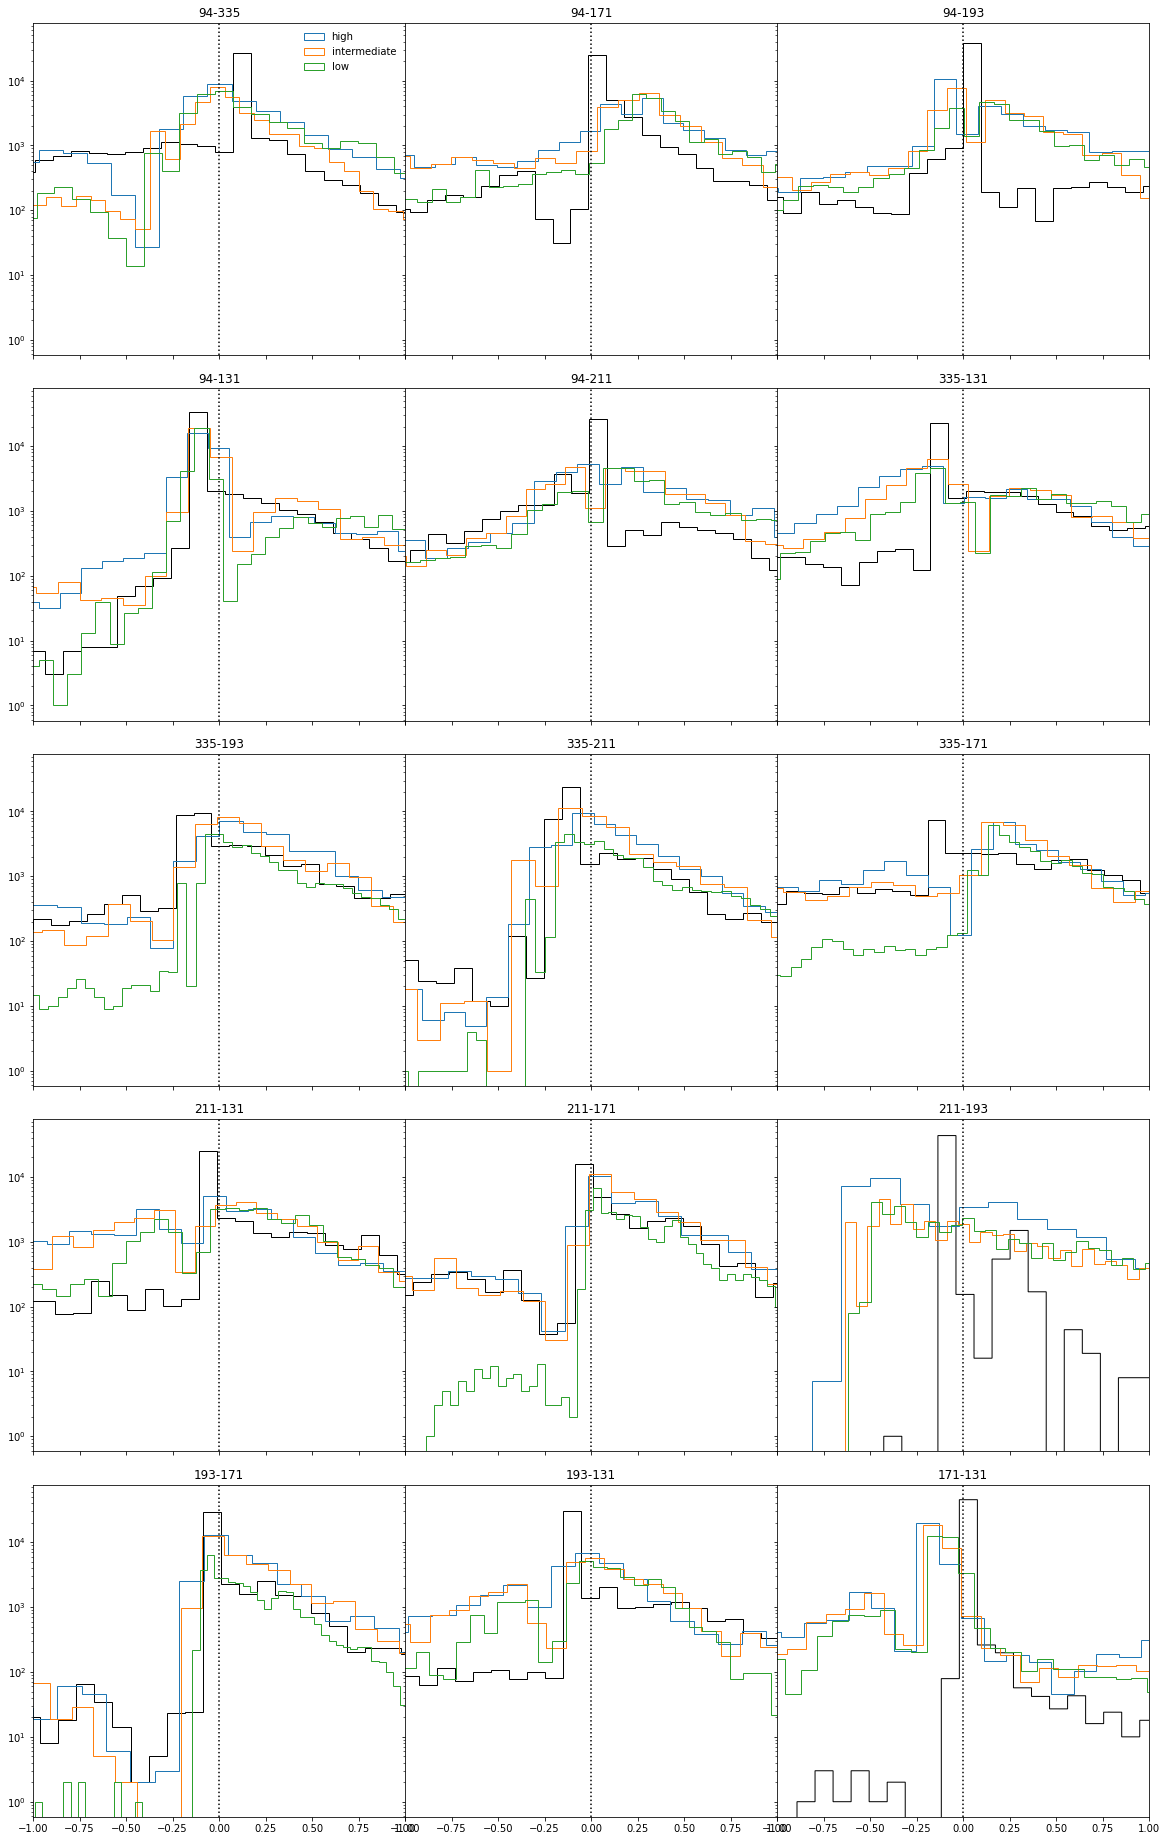

In [136]:
bins = 'scott'#np.arange(-(3*u.h).to(u.s).value,(3*u.h).to(u.s).value,120)
fig,axes = plt.subplots(5,3,figsize=(20,33),sharex=True,sharey=True)
for i,(ca,cb) in enumerate(channel_pairs):
    ax = axes.flatten()[i]
    # Observations
    #m = Map(f'../paper/data/observations/timelag_{ca}_{cb}.fits')
    #mc = Map(f'../paper/data/observations/correlation_{ca}_{cb}.fits')
    ax.hist(X_observation[:,i].squeeze(),bins=bins,color='k',histtype='step');
    # Models
    for j,h in enumerate(heating):
        #m = Map(f'../paper/data/{h}/timelag_{ca}_{cb}.fits')
        #mc = Map(f'../paper/data/{h}/correlation_{ca}_{cb}.fits')
        ax.hist(X[np.where(Y==h),i].squeeze(),bins=bins,color=f'C{j}',histtype='step',
                label=h.split('_')[0]);
    ax.set_title(f'{ca}-{cb}')
    ax.set_yscale('log')
    if i==0:
        ax.legend(frameon=False)
    ax.axvline(x=0,ls=':',color='k')
plt.subplots_adjust(hspace=0.1,wspace=0)
ax.set_xlim(-1e0,1e0);

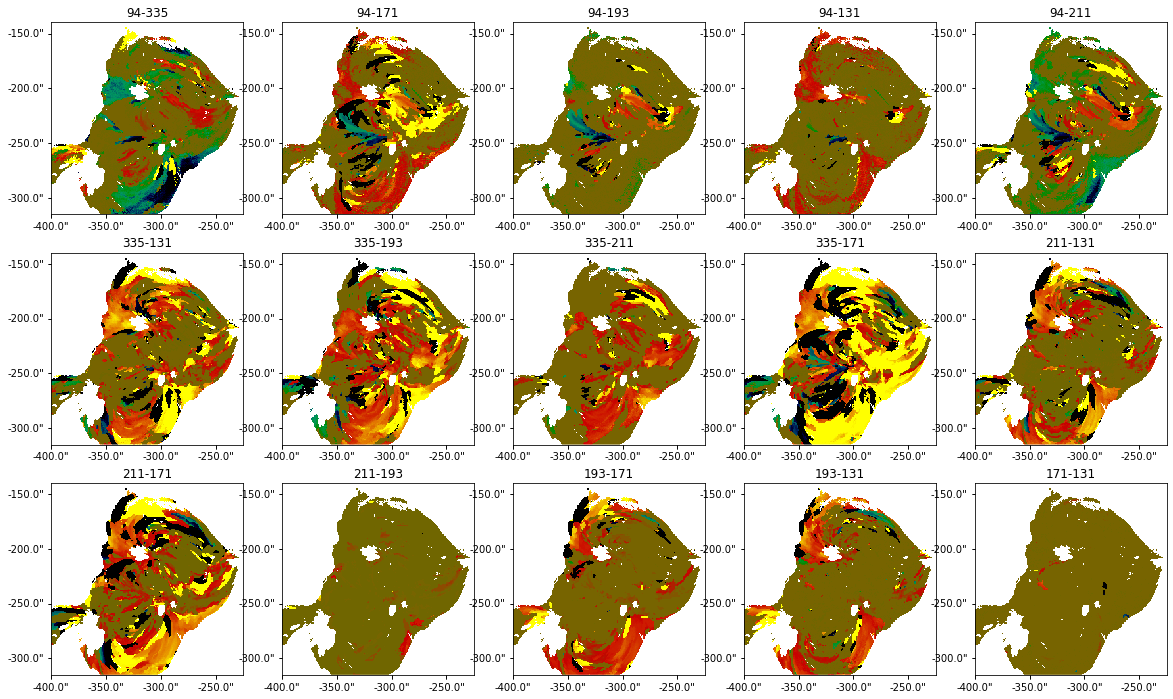

In [63]:
fig = plt.figure(figsize=(20,12))
for i,(ca,cb) in enumerate(channel_pairs):
    m = Map(f'../paper/data/observations/timelag_{ca}_{cb}.fits')
    m = Map(m.data,m.meta,mask=bad_pixels)
    m = m.submap(
        SkyCoord(Tx=-400*u.arcsec,Ty=-315*u.arcsec,frame=m.coordinate_frame),
        SkyCoord(Tx=-225*u.arcsec,Ty=-140*u.arcsec,frame=m.coordinate_frame)
    )
    ax = fig.add_subplot(3,5,i+1,projection=m)
    m.plot(axes=ax,annotate=False,title=False,vmin=-(2*u.h).to(u.s).value,vmax=(2*u.h).to(u.s).value,cmap=bgry_004_idl_cmap)
    ax.grid(alpha=0)
    ax.set_title(f'{ca}-{cb}')

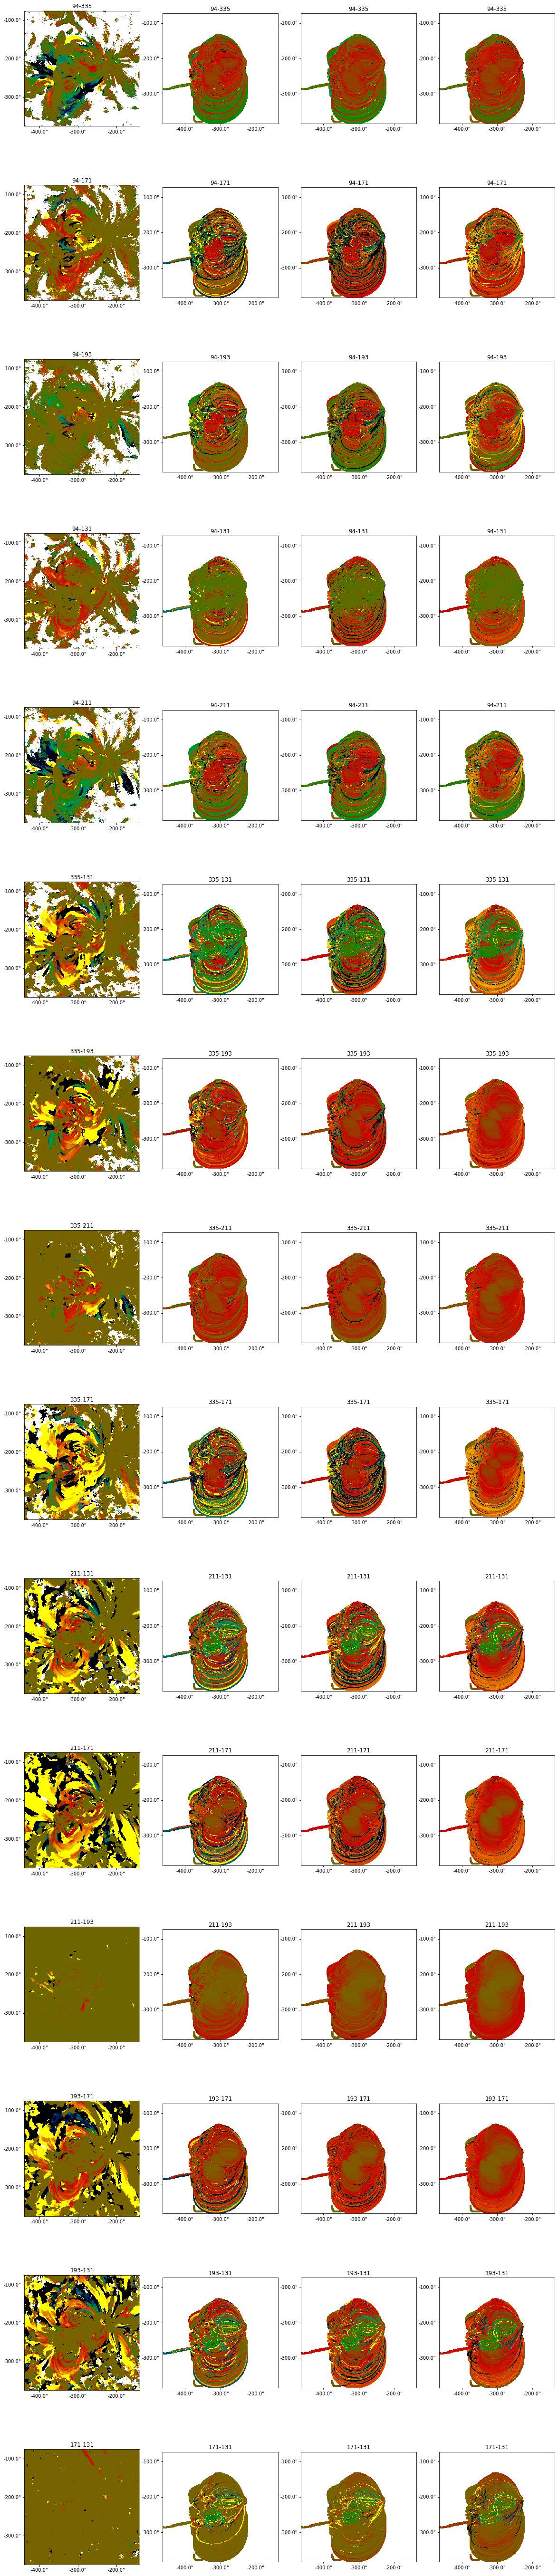

In [73]:
fig = plt.figure(figsize=(20,100))
for i,(ca,cb) in enumerate(channel_pairs):
    for j,h in enumerate(['observations']+heating):
        m = Map(f'../paper/data/{h}/timelag_{ca}_{cb}.fits')
        mc = Map(f'../paper/data/{h}/correlation_{ca}_{cb}.fits')
        m = Map(m.data,m.meta,mask=mc.data<correlation_threshold)
        ax = fig.add_subplot(15,4,j+4*i+1,projection=m)
        m.plot(axes=ax,annotate=False,vmin=-(2*u.h).to(u.s).value,vmax=(2*u.h).to(u.s).value,cmap=bgry_004_idl_cmap)
        ax.grid(alpha=0)
        ax.set_title(f'{ca}-{cb}')

## Classification

Now, we train a Random Forest classifier on our model results.

To start off with, we'll choose a set of parameters that sound the best and we'll run the classifier. Ideally, we should do some hyper parameter tuning here.

In [25]:
frequency_maps = {}
probability_maps = {}

In [26]:
meta = Map('../paper/data/observations/timelag_171_131.fits').meta

In [32]:
rf_options = {
    'n_estimators': 100,#[100, 200, 500],
    'max_features': 'sqrt',
    'max_depth': 50,
    'min_samples_leaf': 0.01,
    #'min_samples_split': 2,
    'criterion': 'gini',
    'bootstrap': True,
    'oob_score': True,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0,
}

### EM Slope

In [33]:
f_map,p_maps,clf,err = classify_ar(rf_options, X[:,-1:], Y, X_observation[:,-1:], bad_pixels,)
frequency_maps['a'] = f_map
probability_maps['a'] = p_maps
print(err)

0.34733229839039137


### Timelags + Cross-Correlation

In [34]:
f_map,p_maps,_,err = classify_ar(rf_options, X[:,:-1], Y, X_observation[:,:-1], bad_pixels)
frequency_maps['b'] = f_map
probability_maps['b'] = p_maps
print(err)

0.03663153307732114


### Timelags + Cross-correlation + EM Slope

In [35]:
f_map,p_maps,clf,err = classify_ar(rf_options, X, Y, X_observation, bad_pixels)
frequency_maps['c'] = f_map
probability_maps['c'] = p_maps
print(err)

0.029931639295149415


### Comparing the Cases

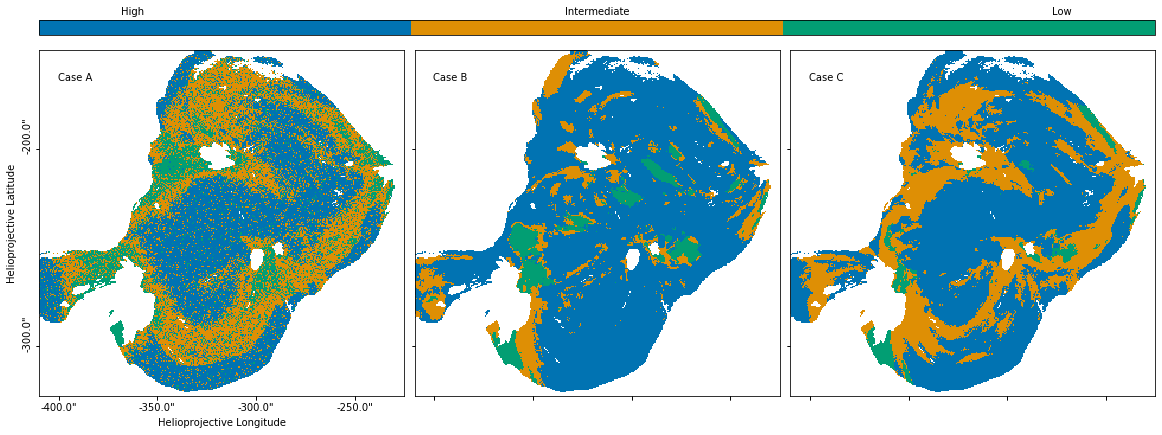

In [36]:
fig = plt.figure(figsize=(20,7))
cax = fig.add_axes([0.125, 0.875, 0.775, 0.03])
plt.subplots_adjust(wspace=0.03)
for i,c in enumerate(('a','b','c')):
    m = GenericMap(frequency_maps[c],meta)
    m = m.submap(SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(1,3,i+1,projection=m)
    im = m.plot(
        axes=ax,
        title=False,
        annotate=False,
        vmin=-0.5,
        vmax=2.5,
        cmap=heating_cmap()
    )
    ax.grid(alpha=0)
    # Axes and ticks
    lon, lat = ax.coords
    if i == 0:
        lon.set_axislabel('Helioprojective Longitude',)
        lat.set_axislabel('Helioprojective Latitude',)
        lat.set_ticklabel(rotation='vertical')
    else:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
    lon.set_ticks(number=4)
    lat.set_ticks(number=2)
    xtext,ytext = m.world_to_pixel(SkyCoord(-400*u.arcsec,-165*u.arcsec,frame=m.coordinate_frame))
    xtext,ytext = int(xtext.value), int(ytext.value)
    ax.text(xtext, ytext, f'Case {c.capitalize()}', color='k', fontsize=plt.rcParams['axes.labelsize'])
# Colorbar
cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_ticks([-0.25,1,2.25])
cbar.ax.set_xticklabels([h.split('_')[0].capitalize() for h in heating],)
cbar.ax.tick_params(axis='x',which='both',length=0)

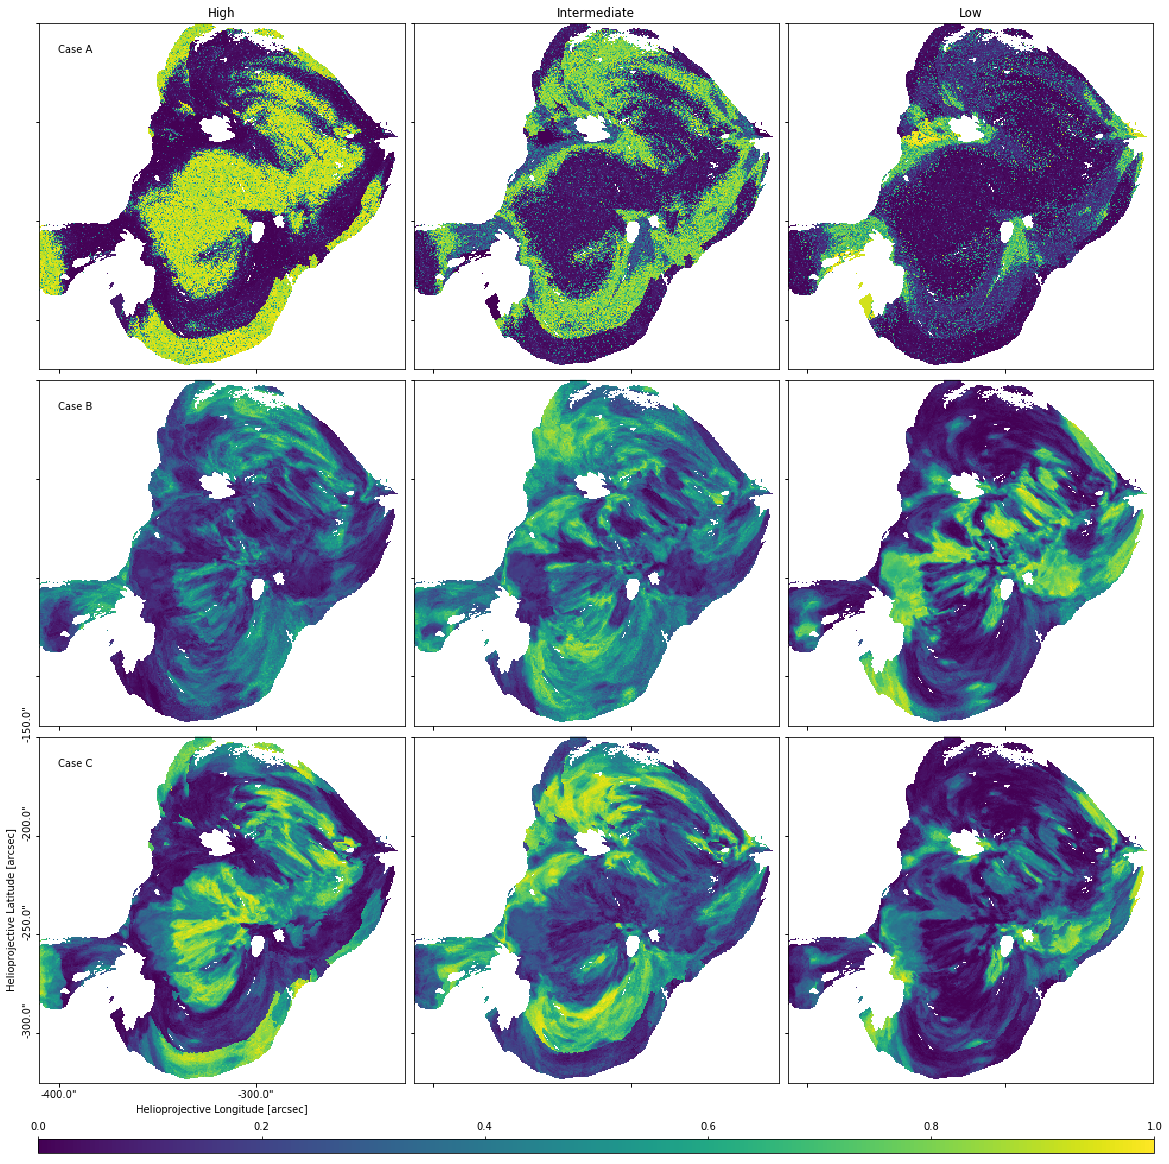

In [135]:
fig = plt.figure(figsize=(20,19.5))
cax = fig.add_axes([0.125, 0.075, 0.775, 0.01])
plt.subplots_adjust(wspace=0.03,hspace=0.03)
for j,c in enumerate(('a','b','c')):
    for i,h in enumerate(heating):
        m = GenericMap(probability_maps[c][h], meta)
        m = m.submap(SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=m.coordinate_frame),
                     SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=m.coordinate_frame))
        ax = fig.add_subplot(3,3,3*j+i+1, projection=m)
        im = m.plot(axes=ax,
                    annotate=False,
                    title=False,
                    vmin=0,
                    vmax=1,
                    cmap='viridis',
                   )
        ax.grid(alpha=0)
        lon,lat = ax.coords
        lon.set_ticks(number=3)
        lat.set_ticks(number=3)
        if i == 0 and j==2:
            lon.set_axislabel('Helioprojective Longitude [arcsec]',)
            lat.set_axislabel('Helioprojective Latitude [arcsec]', )
            lat.set_ticklabel(rotation='vertical')
        else:
            lat.set_ticklabel_visible(False)
            lon.set_ticklabel_visible(False)
        if i == 0:
            xtext,ytext = m.world_to_pixel(SkyCoord(-400*u.arcsec,-165*u.arcsec,frame=m.coordinate_frame))
            xtext,ytext = int(xtext.value), int(ytext.value)
            ax.text(xtext, ytext, f'Case {c.capitalize()}', color='k', fontsize=plt.rcParams['axes.labelsize'])
        if j == 0:
            ax.set_title(h.split('_')[0].capitalize(),)
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
plt.subplots_adjust(wspace=0.02)

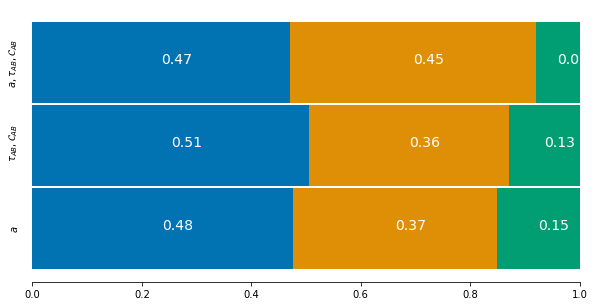

In [51]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
height=1.0
for i,c in enumerate(('a', 'b', 'c')):
    d = frequency_maps[c][~np.isnan(frequency_maps[c])].flatten()
    x0 = d[d == 0].shape[0]/d.shape[0]
    x1 = d[d == 1].shape[0]/d.shape[0]
    x2 = d[d == 2].shape[0]/d.shape[0]
    y = i*1.025
    ax.barh(y,x0,color=heating_palette()[0],height=height,edgecolor=None)
    ax.text(x0/2, y, f'{x0:.2f}',color='w',fontsize=14)
    ax.barh(y,x1,left=x0,color=heating_palette()[1],height=height,edgecolor=None)
    ax.text((2*x0+x1)/2, y, f'{x1:.2f}',color='w',fontsize=14)
    ax.barh(y,x2,left=x0+x1,color=heating_palette()[2],height=height,edgecolor=None)
    ax.text((2*x0+2*x1+x2)/2, y, f'{x2:.2f}',color='w',fontsize=14)
#Labels, Ticks, etc
ax.set_xlim(-0.01,1.01)
ax.set_yticks([0,1.25,2.3,],)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_bounds(0,1)
#ax.set_xticks([])
plt.tick_params(axis='y',which='both',left=False)
ax.set_yticklabels((r'$a$', r'$\tau_{AB},\mathcal{C}_{AB}$', r'$a,\tau_{AB},\mathcal{C}_{AB}$', ),rotation='vertical');

What if we drop every parameter but the slope and the 211-193 Å cross-correlation?

In [87]:
channel_pairs

[(94, 335),
 (94, 171),
 (94, 193),
 (94, 131),
 (94, 211),
 (335, 131),
 (335, 193),
 (335, 211),
 (335, 171),
 (211, 131),
 (211, 171),
 (211, 193),
 (193, 171),
 (193, 131),
 (171, 131)]

In [88]:
f_map,p_maps,clf = classify_ar(
    rf_options,
    X[:,[i for i in range(X.shape[1]) if i == 30 or i == 26]],
    Y,
    X_observation[:,[i for i in range(X_observation.shape[1]) if i == 30 or i == 26]],
    bad_pixels,
)

Test error = 0.17931748236511702


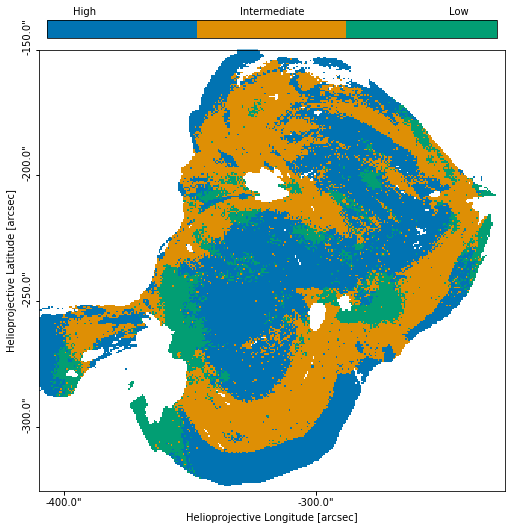

In [89]:
fig = plt.figure(figsize=get_figsize(wf=1.85,))
cax = fig.add_axes([0.275, 0.9, 0.475, 0.03])
f_map = GenericMap(f_map,meta)
m = f_map.submap(
    SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=f_map.coordinate_frame),
    SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=f_map.coordinate_frame)
)
ax = fig.gca(projection=m)
im = m.plot(
    axes=ax,
    title=False,
    annotate=False,
    vmin=-0.5,
    vmax=2.5,
    cmap=heating_cmap()
)
ax.grid(alpha=0)
# Axes and ticks
lon, lat = ax.coords
lat.set_ticklabel(rotation='vertical')
lon.set_axislabel('Helioprojective Longitude [arcsec]',)
lat.set_axislabel('Helioprojective Latitude [arcsec]',)
lon.set_ticks(number=3)
lat.set_ticks(number=3)
# Colorbar
cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_ticks([-0.25,1,2.25])
cbar.ax.set_xticklabels([h.split('_')[0].capitalize() for h in heating],)
cbar.ax.tick_params(axis='x',which='both',length=0)

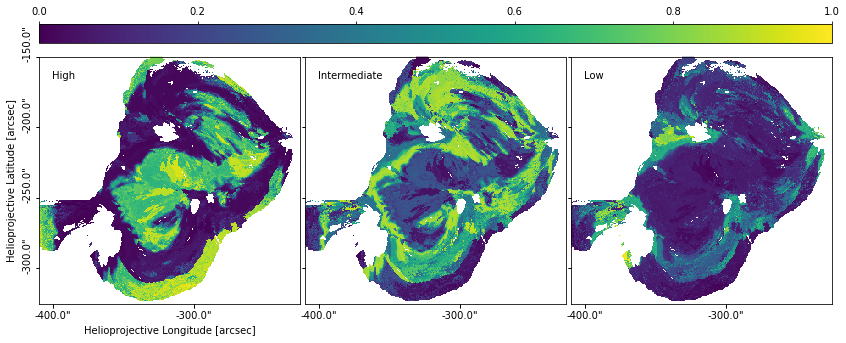

In [22]:
fig = plt.figure(figsize=get_figsize(wf=2,))
cax = fig.add_axes([0.125, 0.72, 0.775, 0.03])
for i,h in enumerate(heating):
    m = GenericMap(p_maps[h],meta)
    m = m.submap(SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(1,3,i+1, projection=m)
    im = m.plot(axes=ax,
                annotate=False,
                title=False,
                vmin=0,
                vmax=1,
                cmap='viridis',
               )
    ax.grid(alpha=0)
    lon,lat = ax.coords
    lon.set_ticks(number=3)
    lat.set_ticks(number=3)
    if i > 0:
        lat.set_ticklabel_visible(False)
    else:
        lat.set_ticklabel(rotation='vertical')
    if i == 0:
        lon.set_axislabel('Helioprojective Longitude [arcsec]',)
        lat.set_axislabel('Helioprojective Latitude [arcsec]', )
    xtext,ytext = m.world_to_pixel(SkyCoord(-400*u.arcsec,-165*u.arcsec,frame=m.coordinate_frame))
    xtext,ytext = int(xtext.value), int(ytext.value)
    ax.text(xtext, ytext, h.split('_')[0].capitalize(), color='k', fontsize=plt.rcParams['axes.labelsize'])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
plt.subplots_adjust(wspace=0.02)

## Figure Code
Make sure not to remove this

Finally, make plots of both the frequency label as well as the probabilites of each class.

For this combined case, let's plot the importance of each of the features in performing the classification in each pixel

Text(0, 0.5, 'Feature Importance')

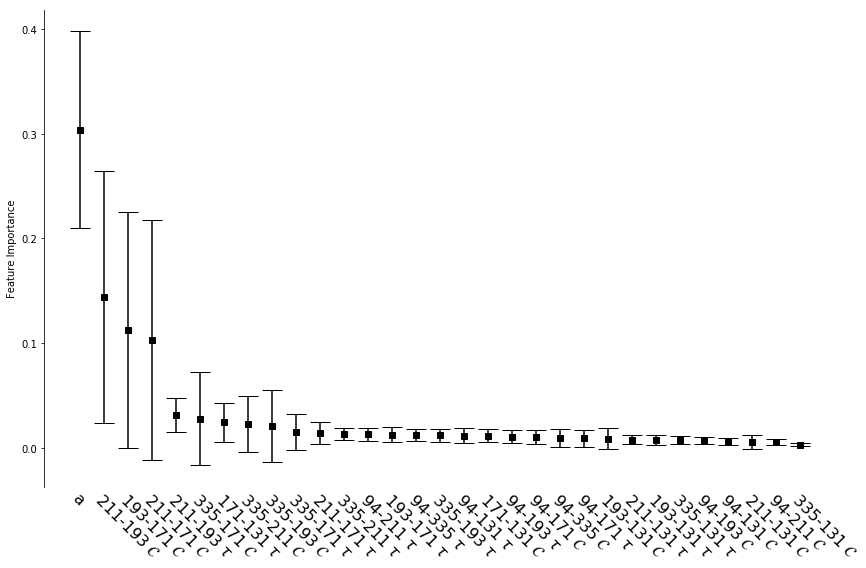

In [25]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
est_std = np.std([t.feature_importances_ for t in clf.estimators_], axis=0)
all_labs = (
    ['{}-{} $\\tau$'.format(*cp) for cp in channel_pairs] +
    ['{}-{} $\mathcal{{C}}$'.format(*cp) for cp in channel_pairs] +
    ['a']
)
indices = indices[:]
fig = plt.figure(figsize=get_figsize(wf=2))
ax = fig.gca()
ax.errorbar(range(indices.shape[0]), importances[indices], yerr=est_std[indices], color='k', ls='', marker='s',capsize=10)
#ax.set_ylim(0,0.2)
#ax.set_yscale('log')
ax.set_xticks(range(indices.shape[0]),);
ax.set_xticklabels(np.array(all_labs)[indices],fontsize=16);
plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode='anchor');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_bounds(ax.get_ylim()[1], ax.get_ylim()[-2])
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('Feature Importance')
#ax.set_yticks(ax.get_yticks()[1:-1:2]);

## Cross-validation via Random Grid Search

In [44]:
grid_parameters = {
    'n_estimators': [500],#[100, 200, 500],
    'max_features': ['sqrt'],
    'max_depth': [None],#[10, 20, 50],
    'min_samples_leaf': [1,50,100,1000],
    'min_samples_split': [2],
    'criterion': ['gini'],
    'bootstrap': [True,],
    'oob_score': [True,],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0],
}

In [45]:
rf = RandomForestClassifier()

In [46]:
#client = distributed.Client()

In [47]:
clf_rcv = RandomizedSearchCV(rf, grid_parameters, n_iter=10, n_jobs=-1, cv=5)

In [48]:
#X_train_dask, X_test_dask, Y_train_dask, Y_test_dask = dask_train_test_split(
#    dask.array.from_array(X_scaled,chunks=X_scaled.shape),
#    dask.array.from_array(Y_encoded,chunks=Y_encoded.shape),
#    test_size=0.33,
#)
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.33)

In [49]:
clf_rcv.fit(X_train, Y_train)

KeyboardInterrupt: 

In [43]:
clf_rcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)